# Project Motivation
With the rise of telederm, users upload a photo of their face to aid dermatologists in the assessment. They then count and determine the type of every acne. However, this process is labour intensive, prone to bias and does not scale well. Hence, being able to identify the type of acne found on the face using computer vision, this creates room for automated acne diagnosis. Alternatively, in recommendation systems for skincare products on ecommerce sites, this data can empower the algorithms behind by acting as an additional source of information to recommend specific products which would be ideal to remedy the acne.

# Project Description
Using our learning model, users can take a photo of themselves and upload it. We will then segment the photo into windows and let the model classify the type of acne. With the output classification, we will then determine the count of every acne type on users’ faces. This will then provide the dermatologist with data to determine the best course of action for the user.

# Steps

First we consolidate all imports here.

In [1]:
import os
from os import listdir, rename, path
from os.path import isfile, join

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from random import randint
import time
import requests
import shutil
import cv2

import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img 
from keras.applications.vgg16 import preprocess_input 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import Counter
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

from bs4 import BeautifulSoup
from PIL import Image

%load_ext autoreload
%autoreload

Get the latest files from the github repository.

In [2]:
!pwd
if not path.exists("/content/CS5242"):
  !git clone https://github.com/simasuiyuan/CS5242.git
else:
  !git pull https://github.com/simasuiyuan/CS5242.git
%cd /content/CS5242

# utility functions of the repo
from project.src.dataLoader import dataLoader
from project.src.utils import image_utils

/content
fatal: not a git repository (or any of the parent directories): .git
/content/CS5242


## 1. Data Scraping
For our dataset, we will be scraping acne images from https://dermnetnz.org/. This section loops through `img` tag of the gallery using BeautifulSoup library and downloads them.

In [3]:
def download_image(image_url, image_name):
    url = image_url
    response = requests.get(url, stream=True)
    with open(image_name, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response

In [4]:
def scrape_dermnet(url):
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    textBlock = soup.find('section', class_="textBlock")
    imgs = textBlock.findAll('img')
    img_dataset = pd.DataFrame([[img.attrs['alt'], "https://dermnetnz.org/" + img.attrs['data-src']] for img in imgs], columns=['alt', 'image_url'])
    img_dataset['image_name'] = [f'scraped_data/image_{e}.jpg' for e in range(img_dataset.shape[0])]
    return img_dataset

In [5]:
# Download images
img_dataset = scrape_dermnet("https://dermnetnz.org/topics/acne-face-images")
import os
print(os.getcwd())
import os.path
from os import path
!pwd
if not path.exists("scraped_data"):
    !mkdir -p scraped_data
    for row in img_dataset.itertuples():
        print(row)
        download_image(row.image_url, row.image_name)

/content/CS5242
/content/CS5242


253 images were successfully scraped.

## 2. Sliding Window

As each facial image may contain multiple acne of different acne types, it will be best to break it into smaller patches to aid with the counting. We will construct a sliding window of size 50 x 50 and stride 50, iterating across each image to generate patches.

In [6]:
images = [join('scraped_data', f) for f in listdir('scraped_data') if isfile(join('scraped_data', f))]

In [7]:
# Set size of sliding window
window_size = 50

In [8]:
# Slicing images
import os
print(os.getcwd())
!mkdir -p temp_dataset
counter = 0
for image_path in images:
    img = np.asarray(Image.open(image_path))
    for i in range(0,img.shape[0],window_size):
        for j in range(0,img.shape[1],window_size):
            sub_img = img[i:i+window_size, j:j+window_size, :]
            # Save image
            img_name = image_path.split('/')[-1].split('.')[0]
            Image.fromarray(sub_img).save(f'temp_dataset/{counter}.jpg')
            counter += 1

/content/CS5242


In [9]:
# Create csv for tagging
cropped_images = sorted([f for f in listdir('temp_dataset') if isfile(join('temp_dataset', f))])
shuffled_images_name = cropped_images.copy()
random.shuffle(shuffled_images_name)
filenames_rows = list(zip(cropped_images, shuffled_images_name))

In [10]:
tagging_df = pd.DataFrame(filenames_rows, columns=['Image File', 'New Image Name'])

In [11]:
# Rename files with shuffled names. Just for illustration. Do not do this as the files are in the downloaded repo already
if False:
    print(os.getcwd())
    !mkdir -p dataset
    for idx, row in tagging_df.iterrows():
        rename(f'temp_dataset/{row["Image File"]}', f'dataset/{row["New Image Name"]}')

In [12]:
tagging_df.head()

,Image File,New Image Name
0,0.jpg,1747.jpg
1,1.jpg,3721.jpg
2,10.jpg,7233.jpg
3,100.jpg,5929.jpg
4,1000.jpg,7223.jpg


In [13]:
tagging_df.to_csv('original_filename.csv', index=False)

Through this process, we generated approximately 7,500 patches. We then manually labelled 1,500 patches as our dataset to split into train and test later on. These patches were labelled as one of these 6 classes:
- Not face - 0
- Normal skin - 1
- Pustule - 2
- Whitehead - 3
- Blackhead - 4
- Cyst - 5


## 3. Getting Label
At this point, we manually labelled almost 2000 images into 1 of the 6 classes above.

In [14]:
# labels already downloaded in github repo
if False:
    !wget "https://raw.githubusercontent.com/simasuiyuan/CS5242/master/labels.csv"
    labels = pd.read_csv('labels.csv')

## 4. Data Exploration and Preprocessing
We load the images and performed image augmentation such that we have an equal number balance of images across the different labels for our training and test set to pick from.

In [15]:
def load_images(labels):
    X = []
    y = []
    for row in labels.itertuples():
        img_path = join('./dataset', row.filename)
        img = load_img(img_path, target_size=(50,50))
        img = np.asarray(img)
        # Keep squares for now
        if img.shape[0] == img.shape[1]:
            y.append(row.label)
            X.append(img)
    return X, y

In [16]:
def augment_data_no_dist_balance(X_train, y_train):
    final_X_train = []
    final_y_train = []
    label_distribution = Counter(y_train)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    print(label_distribution)
    for i in range(len(X_train)):
        final_X_train.append(X_train[i])
        final_X_train.append(rotate(X_train[i], angle=45, mode = 'wrap'))
        final_X_train.append(np.fliplr(X_train[i]))
        final_X_train.append(np.flipud(X_train[i]))
        final_X_train.append(random_noise(X_train[i],var=0.05**2))
        
        final_y_train += [y_train[i]] * 5
    label_distribution = Counter(final_y_train)
    print(label_distribution)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    return final_X_train, final_y_train

def augment_data(X_train, y_train):
    final_X_train = []
    final_y_train = []
    label_distribution = Counter(y_train)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    print(label_distribution)
    max_count_label = max(label_distribution, key=label_distribution.get)
    min_count_label = min(label_distribution, key=label_distribution.get)
    for i in range(len(X_train)):
        label_key = y_train[i]
        if label_distribution[max_count_label] - label_distribution[label_key] >= 10 or label_distribution[max_count_label] - label_distribution[min_count_label] <= 6:
            final_X_train.append(X_train[i])
            angle = 90
            while angle < 360:
                final_X_train.append(rotate(X_train[i], angle=angle, mode = 'wrap'))
                angle+=90
            
            final_X_train.append(random_noise(X_train[i],var=0.05**2))
        
            final_y_train += [y_train[i]] * 5
            label_distribution = Counter(final_y_train)
            max_count = max(label_distribution, key=label_distribution.get)
            min_count = min(label_distribution, key=label_distribution.get)
    print(label_distribution)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    return final_X_train, final_y_train

In [17]:
labels = pd.read_csv('labels.csv')
display(labels.head())
labels.shape

,filename,label
0,1.jpg,1
1,2.jpg,5
2,4.jpg,1
3,5.jpg,2
4,6.jpg,1


(1939, 2)

In [18]:
X, y = load_images(labels)
np.array(X).shape

(1939, 50, 50, 3)

The distribution of the number of raw images and the augmented balanced dataset is show below. Afterwards, we separate the balanced dataset into train and test set with an equal split.

In [19]:
# if no balancing is required, use this instead.
if False:
    X_train, X_test, y_train_df, y_test_df = train_test_split(X, labels, test_size = 0.5, random_state = 12, stratify=y)
    y_train = y_train_df.label.values
    y_test = y_test_df.label.values
    X_train, y_train = augment_data_no_dist_balance(X_train, y_train)

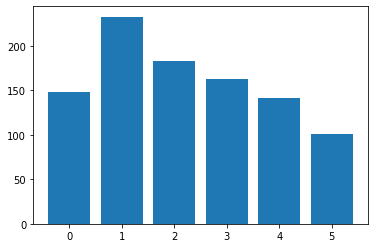

Counter({1: 233, 2: 183, 3: 163, 0: 148, 4: 141, 5: 101})
Counter({1: 515, 2: 515, 0: 510, 4: 510, 3: 510, 5: 505})


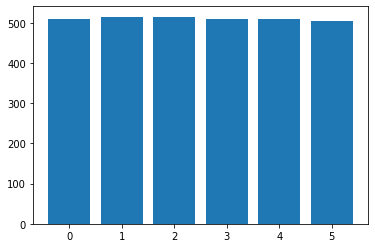

(3065, 50, 50, 3)

In [20]:
X_train, X_test, y_train_df, y_test_df = train_test_split(X, labels, test_size = 0.5, random_state = 45, stratify=y)
y_train = y_train_df.label.values
y_test = y_test_df.label.values
X_train, y_train = augment_data(X_train, y_train)
np.array(X_train).shape

## 5. Networks and Models

The RGB to HSV color space conversion class as well as the different networks  and models used are shown below.

In [21]:
class RGB2HSV(nn.Module):
    def __init__(self):
        super(RGB2HSV, self).__init__()

    def rgb2hsv(self, input, epsilon=1e-5):
        assert(input.shape[1] == 3)
        r, g, b = input[:, 0], input[:, 1], input[:, 2]
        max_rgb, argmax_rgb = input.max(1)
        min_rgb, argmin_rgb = input.min(1)
        max_min = max_rgb - min_rgb + epsilon
        h1 = 60.0 * (g - r) / max_min + 60.0
        h2 = 60.0 * (b - g) / max_min + 180.0
        h3 = 60.0 * (r - b) / max_min + 300.0
        h = torch.stack((h2, h3, h1), dim=0).gather(dim=0, index=argmin_rgb.unsqueeze(0)).squeeze(0)
        s = max_min / (max_rgb + epsilon)
        v = max_rgb
        return torch.stack((h, s, v), dim=1)

    def forward(self,x):
        x = self.rgb2hsv(x)
        scores = x
        return scores
# ================================================================================
class MLP1(nn.Module):

    def __init__(self, input_size, output_size):
        super(MLP1, self).__init__()

        self.layer1 = nn.Linear(in_features=input_size, out_features=output_size, bias=True)

    def forward(self,x):
        x = self.layer1(x)
        scores = x
        return scores
# ================================================================================
class MLP3(nn.Module):

    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(MLP3, self).__init__()

        self.layer1 = nn.Linear(in_features=input_size,    out_features=hidden_size_1, bias=True)
        self.layer2 = nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2, bias=True)
        self.layer3 = nn.Linear(in_features=hidden_size_2, out_features=output_size,   bias=True)

    def forward(self, x):
        x = x.view(-1,self.layer1.in_features)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        scores = x
        return scores
# ================================================================================
class CNN(nn.Module):

    def __init__(self, channel_size):
        super(CNN, self).__init__()

        # Conv2d parameters
        in_channels       = 3
        conv_kernel_size  = 3
        conv_stride       = 1
        conv_padding      = 1
        bias              = True

        # MaxPool2d parameters
        pool_kernel_size  = 2
        pool_stride       = 2
        pool_padding      = 0
        
        # block 1
        self.layer1a = nn.Conv2d(in_channels=in_channels,    out_channels=channel_size*1, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.layer1b = nn.Conv2d(in_channels=channel_size*1, out_channels=channel_size*1, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool1   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

        # block 2
        self.layer2a = nn.Conv2d(in_channels=channel_size*1, out_channels=channel_size*2, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.layer2b = nn.Conv2d(in_channels=channel_size*2, out_channels=channel_size*2, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool2   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

        # block 3
        self.layer3a = nn.Conv2d(in_channels=channel_size*2, out_channels=channel_size*4, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.layer3b = nn.Conv2d(in_channels=channel_size*4, out_channels=channel_size*4, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool3   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

        # block 4
        self.layer4a = nn.Conv2d(in_channels=channel_size*4, out_channels=channel_size*8, kernel_size=conv_kernel_size, stride=conv_stride, padding=conv_padding, bias=bias)
        self.pool4   = nn.MaxPool2d(kernel_size=pool_kernel_size, stride=pool_stride, padding=pool_padding)

    def forward(self, x):
        # block 1
        x = self.layer1a(x)
        x = torch.relu(x)
        x = self.layer1b(x)
        x = torch.relu(x)
        x = self.pool1(x)

        # block 2
        x = self.layer2a(x)
        x = torch.relu(x)
        x = self.layer2b(x)
        x = torch.relu(x)
        x = self.pool2(x)

        # block 3
        x = self.layer3a(x)
        x = torch.relu(x)
        x = self.layer3b(x)
        x = torch.relu(x)
        x = self.pool3(x)

        # block 4
        x = self.layer4a(x)
        x = torch.relu(x)
        x = self.pool4(x)

        scores = x
        return scores
# ================================================================================
class Combined_MLP3(nn.Module):

    def __init__(self, color_space, mlp3, COLOR_TRANS):
        super(Combined_MLP3, self).__init__()
        self.color_space = color_space
        self.mlp3 = mlp3
        self.color_trans = COLOR_TRANS

    def forward(self, x):
        if self.color_trans: x = self.color_space(x)
        x = self.mlp3(x)
        scores = x
        return scores
# ================================================================================
class Combined_CNN_MLP3(nn.Module):

    def __init__(self, color_space, cnn, mlp3, COLOR_TRANS):
        super(Combined_CNN_MLP3, self).__init__()
        self.color_space = color_space
        self.cnn  = cnn
        self.mlp3 = mlp3
        self.color_trans = COLOR_TRANS

    def forward(self, x):
        if self.color_trans: x = self.color_space(x)
        x = self.cnn(x)
        x = self.mlp3(x)
        scores = x
        return scores


Some helper functions for evaluating the accuracy and error scores.

In [22]:
def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    return 100*num_matches.float()/num_data  

def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

def eval_on_test_set(test_data, test_label, net, mean, std, bs, device):

    running_error=0
    running_acc = 0
    num_batches=0

    for i in range(0,100,bs):

        minibatch_data =  test_data[i:i+bs].to(device)
        minibatch_label = test_label[i:i+bs].to(device)
        
        inputs = (minibatch_data - mean)/std

        scores= net( inputs ) 

        error = get_error( scores.detach() , minibatch_label)
        acc = get_accuracy( scores.detach() , minibatch_label)

        running_error += error.item()
        running_acc += acc.item()

        num_batches+=1

    total_error = running_error/num_batches
    total_acc = running_acc/num_batches
    # print(running_error, num_batches)
    print( 'error rate on test set =', total_error*100 ,'percent')
    print('test accuracy =', total_acc)
    return total_error, total_acc

# 6. Training loop

We do an early stop if the model underperforms and is unlikely to improve, or performs well enough (around the best ballpark results we have seen so far) after 50 epochs.

In [23]:
def train_net_MLP(net1, X_train, y_train, X_test, y_test, device, optimizer_func):
    log = {
        "train_loss": [],
        "train_error": [],
        "train_accuracy": [],
        "test_error": [],
        "test_accuracy": [],
    }
    # parameters
    epoch_count      = 100
    batch_size       = 128
    learning_rate    = 0.001

    X_train = X_train.view(-1, 3, 50, 50)
    X_test = X_test.view(-1, 3, 50, 50)
    train_data_count = X_train.shape[0]
    mean = X_train.mean().to(device)
    std = X_train.std().to(device)

    # objects
    criterion = nn.CrossEntropyLoss()

    # training loop
    start = time.time()
    for epoch in range(epoch_count):

        # statistics
        running_loss=0
        running_error=0
        running_accuracy = 0
        num_batches=0

        # objects - new optimizer each epoch

        optimizer = optimizer_func(net1.parameters(), lr=learning_rate)

        # sample inputs randomly
        shuffled_indices = torch.randperm(train_data_count)

        # minibatch loop
        for count in range(0, train_data_count, batch_size):

            # reset gradients
            optimizer.zero_grad()

            # create minibatch
            indices = shuffled_indices[count:count+batch_size].to(device)
            minibatch_data =  X_train[indices].to(device)
            minibatch_label =  y_train[indices].to(device)
            
            # forward pass
            inputs = (minibatch_data - mean) / std
            inputs.requires_grad_()
            scores = net1(inputs)
            loss   = criterion(scores, minibatch_label)

            # backward pass
            loss.backward()
            optimizer.step()

            # statistics (with detach to prevent accumulation)
            running_loss += loss.detach().item()
            error = get_error( scores.detach() , minibatch_label)
            acc = get_accuracy(scores.detach() , minibatch_label)
            running_error += error.item()
            running_accuracy += acc.item()
            num_batches +=1


        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        total_acc = running_accuracy/num_batches
        log["train_loss"].append(total_loss)
        log["train_error"].append(total_error)
        log["train_accuracy"].append(total_acc)
    
        print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        print('train accuracy =', total_acc)
        print(' ')

        test_error,test_acc = eval_on_test_set(X_test, y_test, net1, mean, std, batch_size,device=device)

        log["test_error"].append(test_error)
        log["test_accuracy"].append(test_acc)
        print("="*50)

        if (epoch > 50 and ((abs(total_acc-test_acc)<0) or test_acc>38 or test_acc<20)) or (epoch > 50 and abs(total_acc-test_acc)>30): break
    return log
# ================================================================================
def train_net_VGG(net1, X_train, y_train, X_test, y_test, device, optimizer_func, learning_rate=3e-6, early_stop=True):
    log = {
        "train_loss": [],
        "train_error": [],
        "train_accuracy": [],
        "test_error": [],
        "test_accuracy": [],
    }
    # parameters
    epoch_count      = 100
    batch_size       = 128
    learning_rate    = learning_rate

    X_train = X_train.view(-1, 3, 50, 50)
    X_test = X_test.view(-1, 3, 50, 50)
    train_data_count = X_train.shape[0]
    mean = X_train.mean().to(device)
    std = X_train.std().to(device)

    # objects
    criterion = nn.CrossEntropyLoss()

    # training loop
    start = time.time()
    for epoch in range(epoch_count):

        # statistics
        running_loss=0
        running_error=0
        running_accuracy = 0
        num_batches=0

        # objects - new optimizer each epoch

        optimizer = optimizer_func(net1.parameters(), lr=learning_rate)

        # sample inputs randomly
        shuffled_indices = torch.randperm(train_data_count)

        # minibatch loop
        for count in range(0, train_data_count, batch_size):

            # reset gradients
            optimizer.zero_grad()

            # create minibatch
            indices = shuffled_indices[count:count+batch_size].to(device)
            minibatch_data =  X_train[indices].to(device)
            minibatch_label =  y_train[indices].to(device)
            
            # forward pass
            inputs = (minibatch_data - mean) / std
            inputs.requires_grad_()
            scores = net1(inputs)
            loss   = criterion(scores, minibatch_label)

            # backward pass
            loss.backward()
            optimizer.step()

            # statistics (with detach to prevent accumulation)
            running_loss += loss.detach().item()
            error = get_error( scores.detach() , minibatch_label)
            acc = get_accuracy(scores.detach() , minibatch_label)
            running_error += error.item()
            running_accuracy += acc.item()
            num_batches +=1


        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        total_acc = running_accuracy/num_batches
        log["train_loss"].append(total_loss)
        log["train_error"].append(total_error)
        log["train_accuracy"].append(total_acc)
    
        print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        print('train accuracy =', total_acc)
        print(' ')

        test_error,test_acc = eval_on_test_set(X_test, y_test, net1, mean, std, batch_size,device=device)

        log["test_error"].append(test_error)
        log["test_accuracy"].append(test_acc)
        print("="*50)
        if early_stop:
            if (epoch > 50 and ((abs(total_acc-test_acc)<0) or test_acc>38 or test_acc<20)) or (epoch > 50 and abs(total_acc-test_acc)>30): break
    return log

## 7. Network instantiation

We define for 1 MLP model with 3 layers and a VGG model that uses both CNN layers and 3 linear layers.

In [24]:
def create_net_MLP(num_class=6, COLOR_TRANS=True):
    # parameters
    input_size    = 3*50*50
    hidden_size_1 = 4608*2
    hidden_size_2 = 2048
    output_size   = num_class

    # modules
    rgb_to_hsv = RGB2HSV()
    mlp3 = MLP3(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size)
    net1 = Combined_MLP3(color_space=rgb_to_hsv, mlp3=mlp3, COLOR_TRANS=False)
    return net1
# ================================================================================
def create_net_VGG(num_class=6, COLOR_TRANS=True):
    # parameters
    channel_size  = 64
    input_size    = 4608
    hidden_size_1 = 4608*2
    hidden_size_2 = 2048
    output_size   = num_class

    # modules
    rgb_to_hsv = RGB2HSV()
    cnn  = CNN(channel_size=channel_size) # 4608
    mlp3 = MLP3(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size)
    net1 = Combined_CNN_MLP3(color_space=rgb_to_hsv, cnn=cnn, mlp3=mlp3, COLOR_TRANS=COLOR_TRANS)
    return net1

In [25]:
def case_MLP(X_train, y_train, X_test, y_test, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    net = create_net_MLP(num_class=6, COLOR_TRANS=False).to(device) # RGB
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    log = train_net_MLP(net, X_train, y_train, X_test, y_test, device=device, optimizer_func=torch.optim.Adam) # Adam
    return net,log
# ================================================================================
def case_VGG1(X_train, y_train, X_test, y_test, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    net = create_net_VGG(num_class=6, COLOR_TRANS=True).to(device) # HSV
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    log = train_net_VGG(net, X_train, y_train, X_test, y_test, device=device, optimizer_func=torch.optim.SGD) # SGD
    return net,log
# ================================================================================
def case_VGG2(X_train, y_train, X_test, y_test, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    net = create_net_VGG(num_class=6, COLOR_TRANS=False).to(device) # RGB
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    log = train_net_VGG(net, X_train, y_train, X_test, y_test, device=device, optimizer_func=torch.optim.Adam) # Adam
    return net,log
# ================================================================================
def case_VGG3(X_train, y_train, X_test, y_test, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    net = create_net_VGG(num_class=6, COLOR_TRANS=True).to(device) # HSV
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    log = train_net_VGG(net, X_train, y_train, X_test, y_test, device=device, optimizer_func=torch.optim.Adam) # Adam
    return net,log
# ================================================================================
def case_VGG4(X_train, y_train, X_test, y_test, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    net = create_net_VGG(num_class=6, COLOR_TRANS=True).to(device) # HSV
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    log = train_net_VGG(net, X_train, y_train, X_test, y_test, device=device, optimizer_func=torch.optim.Adam, learning_rate=3e-7, early_stop=False) # Adam
    return net,log

## 8. Training
Select a model to train. We have 5 different configurations here.
The configurations are as follows:

Network Model      | optimizer        |color space       |learning rate
-------------------|------------------|------------------|------------------
MLP                | Adam             | RGB              | 1e-3
VGG16              | SGD              | HSV              | 3e-6
VGG16              | Adam             | RGB              | 3e-6
VGG16              | Adam             | HSV              | 3e-6
VGG16              | Adam             | HSV              | 3e-7


In [26]:
print("========== START TRAINING MODEL 1 ========== ")
print()
# net_model1, log1 = case_MLP(X_train, y_train, X_test, y_test)
print("========== START TRAINING MODEL 2 ========== ")
print()
# net_model2, log2 = case_VGG1(X_train, y_train, X_test, y_test)
print("========== START TRAINING MODEL 3 ========== ")
print()
# net_model3, log3 = case_VGG2(X_train, y_train, X_test, y_test)
print("========== START TRAINING MODEL 4 ========== ")
print()
net_model4, log4 = case_VGG3(X_train, y_train, X_test, y_test) # best model
print("========== START TRAINING MODEL 5 ========== ")
print()
# net_model5, log5 = case_VGG4(X_train, y_train, X_test, y_test)
print("========== ALL TRAINING DONE ========== ")

========== START TRAINING MODEL 1 ========== 

========== START TRAINING MODEL 2 ========== 

========== START TRAINING MODEL 3 ========== 

========== START TRAINING MODEL 4 ========== 

epoch= 0 	 loss= 1.790929486354192 	 error= 81.4176027973493 percent
train accuracy = 18.5823970635732
 
error rate on test set = 66.40625 percent
test accuracy = 33.59375
epoch= 1 	 loss= 1.7830673654874165 	 error= 78.72707893451056 percent
train accuracy = 21.272920926411945
 
error rate on test set = 86.71875 percent
test accuracy = 13.28125
epoch= 2 	 loss= 1.7693029542764027 	 error= 74.13911844293276 percent
train accuracy = 25.860881487528484
 
error rate on test set = 64.0625 percent
test accuracy = 35.9375
epoch= 3 	 loss= 1.751189077893893 	 error= 73.86175319552422 percent
train accuracy = 26.138246774673462
 
error rate on test set = 80.46875 percent
test accuracy = 19.53125
epoch= 4 	 loss= 1.734564130504926 	 error= 73.8999548057715 percent
train accuracy = 26.10004512468974
 
error rat

In [27]:
# to save the model if needed
if False:
    model = net_model
    torch.save(model.state_dict(), "./models/net_model")
    model = create_net_VGG(num_class=6, COLOR_TRANS=True).to(device)
    model.load_state_dict(torch.load("./models/net_model"))
    model.eval()

## 9. Plotting functions

In [28]:
index_df = y_test_df.copy()
index_df["file_idx"] = index_df.filename.str.split('.').str[0].astype(int)
index_df = index_df.reset_index()
index_df

,index,filename,label,file_idx
0,357,400.jpg,2,400
1,1133,1270.jpg,1,1270
2,137,151.jpg,2,151
3,540,597.jpg,2,597
4,825,927.jpg,2,927
...,...,...,...,...
965,1155,1293.jpg,4,1293
966,964,1081.jpg,2,1081
967,128,142.jpg,0,142
968,458,506.jpg,1,506


In [29]:
# Dont run this unless you confirm to modify label
if False:
    def modify_label(df, image_idx, label):
        file_name = str(image_idx)+".jpg"
        display(df.loc[df["filename"]==file_name])
        df.loc[df["filename"]==file_name, "label"] = label
        display(df.loc[df["filename"]==file_name])

    modify = True
    if modify:
        modify_label(labels, idx, 1)

In [30]:
def rand_show_prob(net_model):
    # choose a picture at random
    for times in range(2):
        idx=randint(0, len(X_test))
        label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)
        print(idx)
        im=X_test[idx].astype(np.uint8)

        # diplay the picture
        image_label = f"label index: {y_test[idx]}; label is {label[y_test[idx]]}; image name is {y_test_df.reset_index().iloc[idx,1]}"
        image_utils().plot_image(im,title=image_label, figsize=(5,5))

        # rescale, and view as a batch of 1 
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        im=X_test[idx].astype(np.uint8)
        im = torch.from_numpy(np.array(im).astype(np.float32)).to(device)
        X_train_ = torch.from_numpy(np.array(X_train).astype(np.float32))
        X_train_ = X_train_.view(-1, 3, 50, 50)
        mean= X_train_.mean()
        std= X_train_.std()
        im= (im-mean) / std
        im=im.view(1,3,50,50)

        # feed it to the net and display the confidence scores
        scores = net_model(im) 
        probs= torch.softmax(scores, dim=1)
        image_utils().show_prob_pimples(probs.cpu())

In [31]:
import plotly.express as px
def show_plot(log):
    log_df = pd.DataFrame.from_dict(log)
    log_df = log_df.reset_index()
    fig = px.line(log_df.iloc[1:], x="index", y="train_loss")
    fig.update_layout(width=1000)
    fig.show()
    type = "accuracy"
    df1 = log_df[['index', f"train_{type}", f"test_{type}"]].melt(id_vars=['index'], var_name='log_type')
    fig = px.line(df1, x="index", y="value", color='log_type')
    fig.update_layout(width=1000)
    fig.show()

    type = "error"
    df1 = log_df[['index', f"train_{type}", f"test_{type}"]].melt(id_vars=['index'], var_name='log_type')
    fig = px.line(df1, x="index", y="value", color='log_type')
    fig.update_layout(width=1000)
    fig.show()

## 10. Confusion matrix functions

In [32]:
def compute_acc_and_conf_mat(scores, actual_labels):
    y_pred = scores.detach().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    indicator = (y_pred == actual_labels)
    num_matches = indicator.sum()
    acc = 100*num_matches/len(y_pred)
    conf_mat = confusion_matrix(actual_labels, y_pred)
    return acc, conf_mat

import plotly.graph_objects as go
def plot_confusion_matrix(cm, labels, title):
    # cm : confusion matrix list(list)
    # labels : name of the data list(str)
    # title : title for the heatmap
    data = go.Heatmap(z=cm, y=labels, x=labels, colorscale="BuPu")
    annotations = []
    for i, row in enumerate(cm):
        for j, value in enumerate(row):
            annotations.append(
                {
                    "x": labels[i],
                    "y": labels[j],
                    "font": {"color": "white"},
                    "text": str(value),
                    "xref": "x1",
                    "yref": "y1",
                    "showarrow": False
                }
            )
    layout = {
        "title": title,
        "xaxis": {"title": "Predicted value"},
        "yaxis": {"title": "Real value"},
        "annotations": annotations,
        "width":500,
        "height":500,
    }
    fig = go.Figure(data=data, layout=layout)
    return fig

def show_conf_matrix(net_model):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_test_ = torch.from_numpy(np.array(X_test).astype(np.float32)).to(device)
    X_train_ = torch.from_numpy(np.array(X_train).astype(np.float32))
    X_train_ = X_train_.view(-1, 3, 50, 50)
    mean= X_train_.mean()
    std= X_train_.std()
    X_test_= (X_test_-mean) / std
    X_test_ = X_test_.view(-1, 3, 50, 50)
    scores =  net_model(X_test_)
    acc, conf_mat = compute_acc_and_conf_mat(scores.cpu(),y_test)
    label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)
    plot_confusion_matrix(conf_mat, label, "confusion matrix")
    return conf_mat

label = ('Not Skin', 'Normal', 'Pustule', 'Whitehead', 'Blackhead', 'Cyst',)

## 11. Analysis and Comparison

Here we show a random selection and its probability distribution, the different plots of loss, accuracy, and error, as well as the confusion matrix of the networked trained above.

317


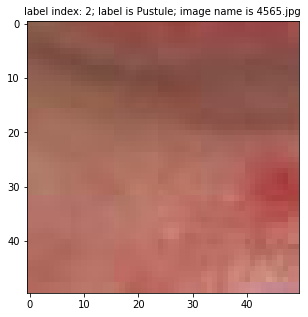

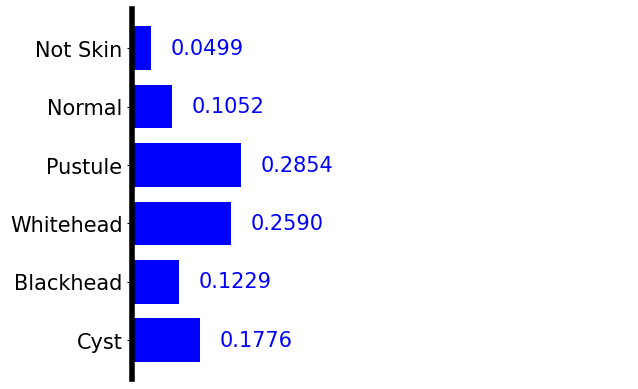

523


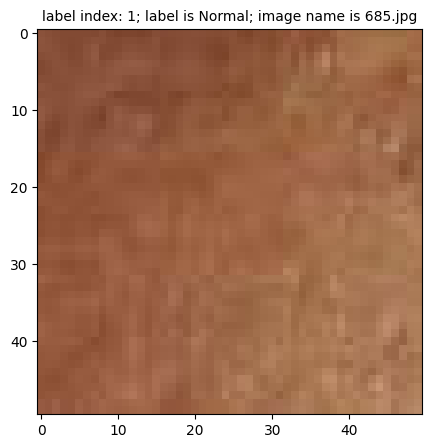

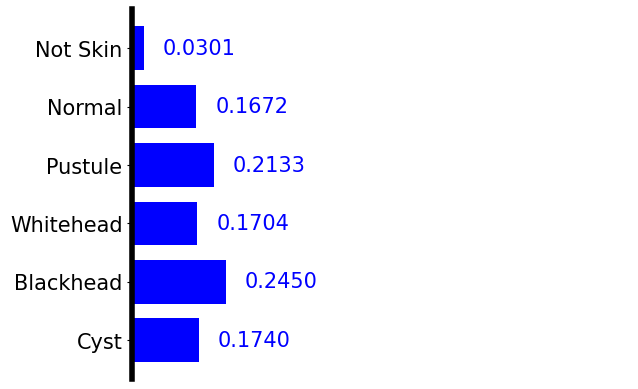

In [33]:
rand_show_prob(net_model4)
show_plot(log4)
conf_mat4 = show_conf_matrix(net_model4)
plot_confusion_matrix(conf_mat4, label, "confusion matrix")